# Project Deliverable 2: Regression Modeling and Performance Evaluation
**Student Name:** Gaurab Karki  
**Course:** 2025 Fall - Advanced Big Data and Data Mining (MSCS-634-B01)

**Dataset:** Healthcare Dataset (Kaggle)  
**Source:** [https://www.kaggle.com/datasets/prasad22/healthcare-dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset)

# Description
This notebook builds regression models to predict **Billing Amount** using the healthcare dataset prepared in Deliverable 1.  
I have performed feature engineering (temporal features, length of stay), create encodings for categorical variables, train at least two regression models (Linear, Ridge, Lasso), evaluate with R² / MSE / RMSE / MAE, use K-Fold cross-validation, and present multiple visualizations to support model selection and insights.

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', context='notebook')

#### Load Dataset

In [2]:
df = pd.read_csv('healthcare_dataset.csv')
print("Shape:", df.shape)
display(df.head())

Shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


# Task 1: Data review & quick cleaning
Brief: I have reused Deliverable 1 cleaning (standardize text, convert dates). I will create derived features: Length_of_Stay, Adm_Year, Adm_Month, and also reduce high-cardinality categories to top-k and group the rest as "Other" to keep the feature space manageable.

In [3]:
data = df.copy()
data.columns = [c.strip() for c in data.columns]

# Convert date columns to datetime (coerce errors to NaT)
for col in ['Date of Admission', 'Discharge Date']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Create Length_of_Stay and admission year/month where possible
if 'Date of Admission' in data.columns and 'Discharge Date' in data.columns:
    data['Length_of_Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
    # treat invalid values as missing
    data.loc[(data['Length_of_Stay'] < 0) | (data['Length_of_Stay'] > 3650), 'Length_of_Stay'] = np.nan

if 'Date of Admission' in data.columns:
    data['Adm_Year'] = data['Date of Admission'].dt.year
    data['Adm_Month'] = data['Date of Admission'].dt.month

# Convert Room Number to numeric if present
if 'Room Number' in data.columns:
    data['Room Number'] = pd.to_numeric(data['Room Number'], errors='coerce')

# Standardize string fields
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype(str).str.strip()

# Reduce cardinality for several categorical columns by keeping top-k values
def keep_top_k(series, k=10):
    topk = series.value_counts().nlargest(k).index
    return series.where(series.isin(topk), other='Other')

high_card_cols = ['Doctor', 'Hospital', 'Medication', 'Medical Condition', 'Insurance Provider']
for c in high_card_cols:
    if c in data.columns and data[c].nunique() > 10:
        data[c] = keep_top_k(data[c], k=10)

# Drop raw date columns (we keep derived features)
for c in ['Date of Admission', 'Discharge Date']:
    if c in data.columns:
        data = data.drop(columns=[c])

print("Columns after FE:", data.columns.tolist())
display(data.head())

Columns after FE: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Medication', 'Test Results', 'Length_of_Stay', 'Adm_Year', 'Adm_Month']


,Name,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication,Test Results,Length_of_Stay,Adm_Year,Adm_Month
0,Bobby JacksOn,30,Male,B-,Cancer,Matthew Smith,Other,Blue Cross,18856.281306,328,Urgent,Paracetamol,Normal,2.0,2024,1
1,LesLie TErRy,62,Male,A+,Obesity,Other,Other,Medicare,33643.327287,265,Emergency,Ibuprofen,Inconclusive,6.0,2019,8
2,DaNnY sMitH,76,Female,A-,Obesity,Other,Other,Aetna,27955.096079,205,Emergency,Aspirin,Normal,15.0,2022,9
3,andrEw waTtS,28,Female,O+,Diabetes,Other,Other,Medicare,37909.782410,450,Elective,Ibuprofen,Abnormal,30.0,2020,11
4,adrIENNE bEll,43,Female,AB+,Cancer,Other,Other,Aetna,14238.317814,458,Urgent,Penicillin,Abnormal,20.0,2022,9


# Task 2: Exploratory Visualizations
Here, I will visualize target distribution, key feature distributions, correlations and top categories. This helps me to identify skew, outliers, and candidate predictors.

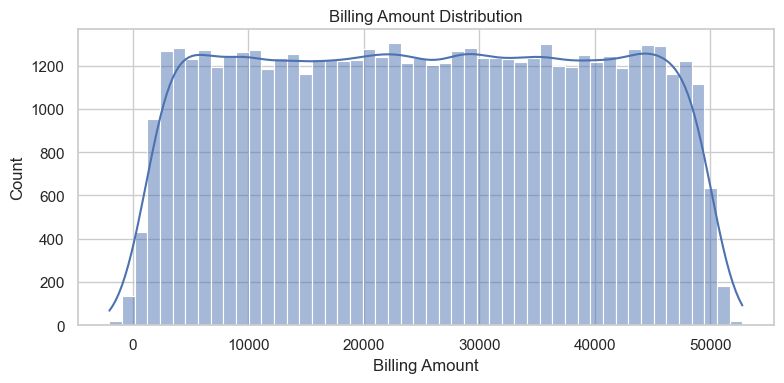

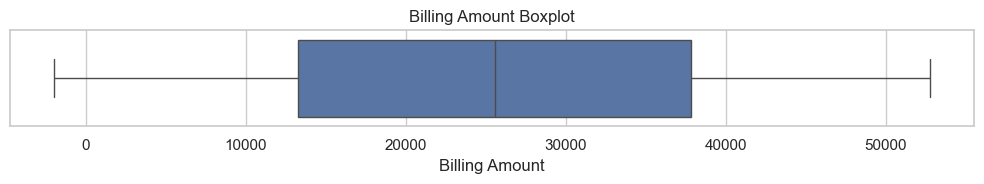

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(data['Billing Amount'].dropna(), kde=True, bins=50)
plt.title('Billing Amount Distribution')
plt.xlabel('Billing Amount')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot to show outliers
plt.figure(figsize=(10,2))
sns.boxplot(x=data['Billing Amount'].dropna())
plt.title('Billing Amount Boxplot')
plt.tight_layout()
plt.show()

#### Numeric distributions for Age, Length_of_Stay, Room Number, Adm_Year, Adm_Month

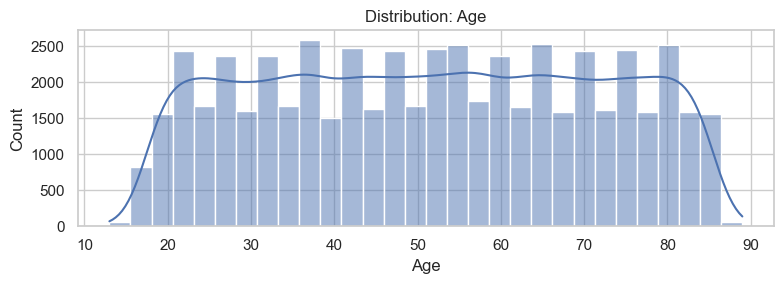

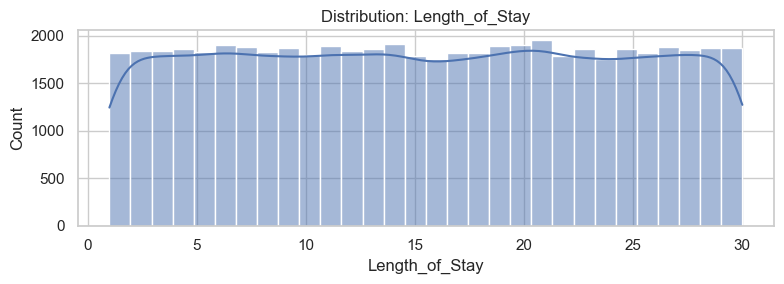

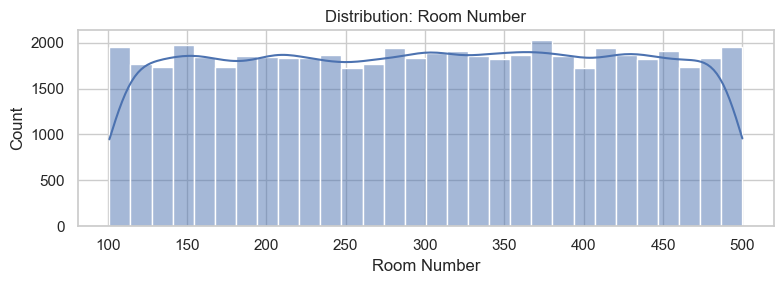

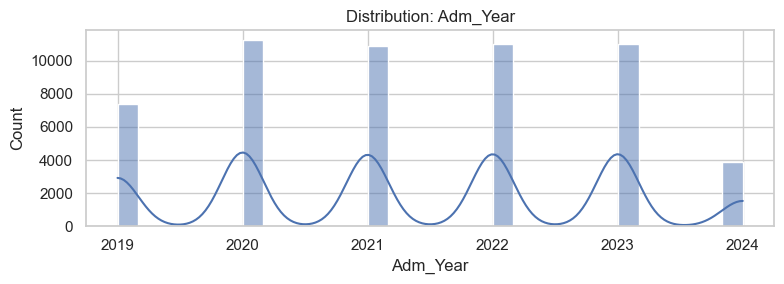

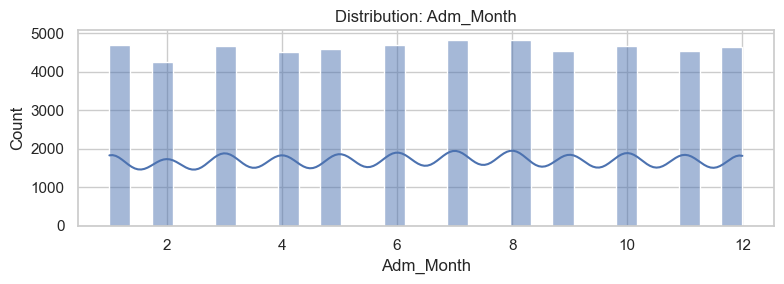

In [5]:
num_cols = [c for c in ['Age', 'Length_of_Stay', 'Room Number', 'Adm_Year', 'Adm_Month'] if c in data.columns]
for c in num_cols:
    plt.figure(figsize=(8,3))
    sns.histplot(data[c].dropna(), kde=True, bins=30)
    plt.title(f'Distribution: {c}')
    plt.tight_layout()
    plt.show()

#### Top categories for selected categorical cols

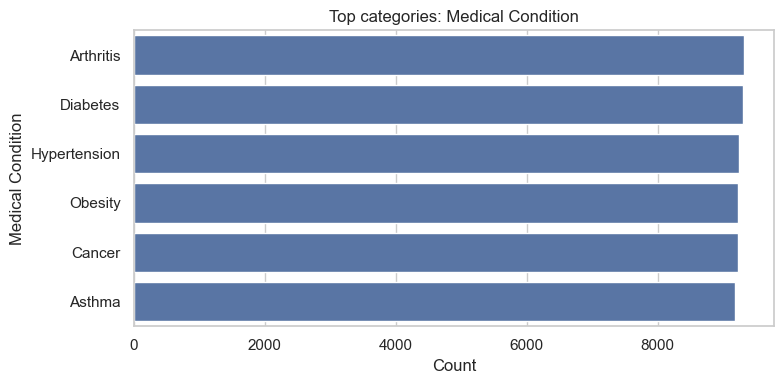

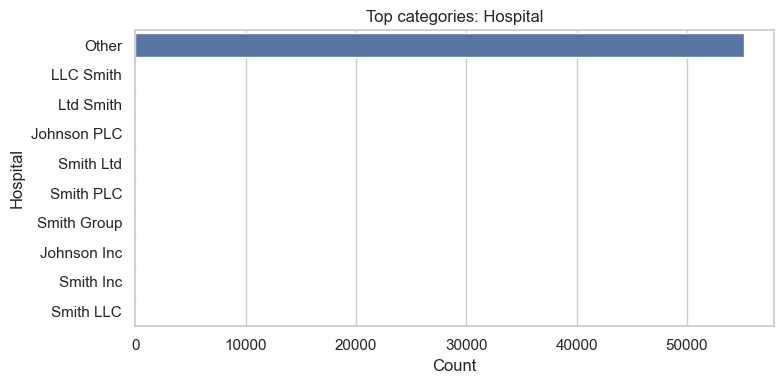

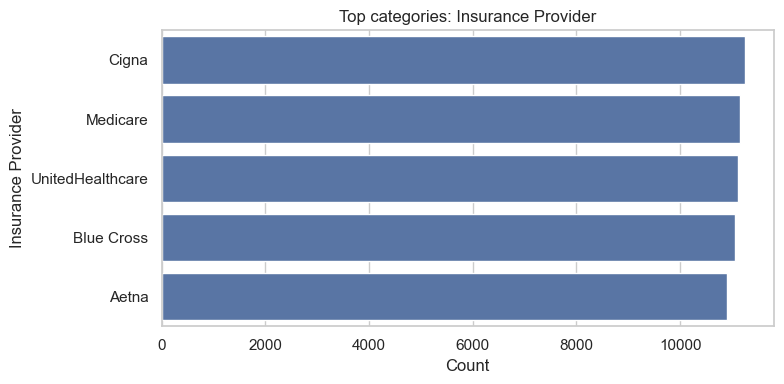

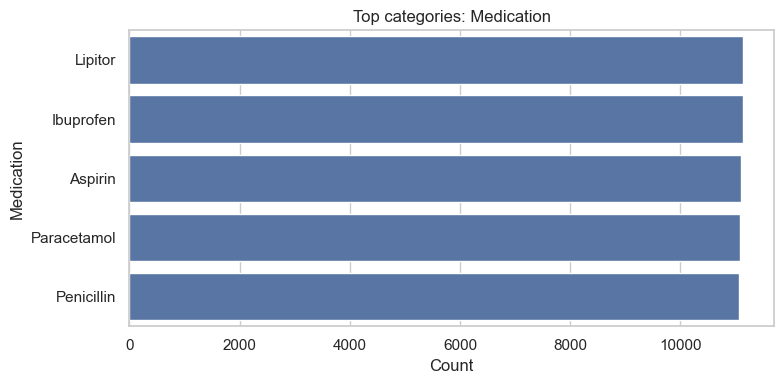

In [6]:
cat_plot_cols = [c for c in ['Medical Condition', 'Hospital', 'Insurance Provider', 'Medication'] if c in data.columns]
for c in cat_plot_cols:
    vc = data[c].value_counts().nlargest(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f'Top categories: {c}')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

#### Correlation heatmap for numeric columns

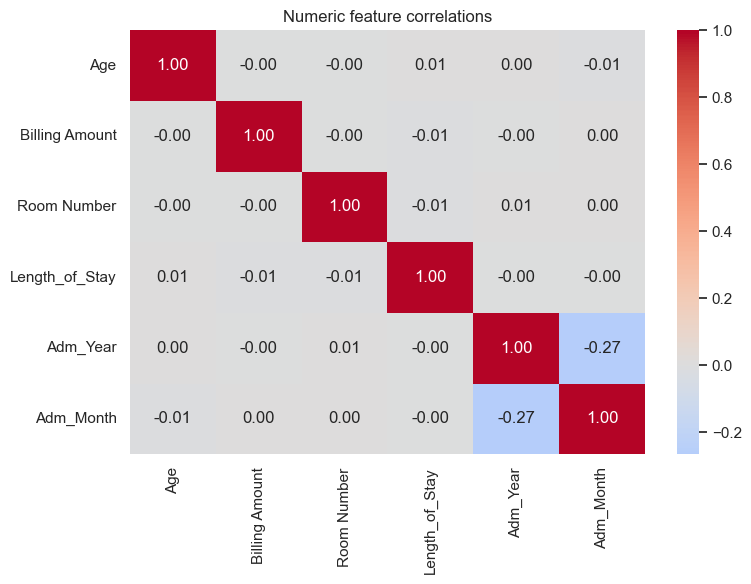

In [7]:
numeric_for_corr = data.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(8,6))
sns.heatmap(data[numeric_for_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Numeric feature correlations')
plt.tight_layout()
plt.show()

# Task 3: Prepare data for modeling (split, preprocess pipelines)
Here, I will impute missing values: numeric -> median; categorical -> most frequent. One-hot encode categoricals; scale numeric features, and create train/test split.

#### Target & predictors

In [8]:
TARGET = 'Billing Amount'
if TARGET not in data.columns:
    raise KeyError("Billing Amount column missing")

X = data.drop(columns=[TARGET])
y = data[TARGET].astype(float)

#### Identify numeric and categorical predictors

In [9]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features (sample):", categorical_features[:10])

Numeric features: ['Age', 'Room Number', 'Length_of_Stay', 'Adm_Year', 'Adm_Month']
Categorical features (sample): ['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']


#### Preprocessing pipelines

In [10]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


#### Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (44400, 15) Test shape: (11100, 15)


# Task 4: Model development (Linear, Ridge, Lasso) + cross-validation
Here, I will train baseline Linear Regression and then tune Ridge and Lasso using small GridSearchCV. Use 5-fold CV for final evaluation where practical.

In [ ]:
# Define pipelines
pipe_lr = Pipeline(steps=[('pre', preprocessor), ('reg', LinearRegression())])
pipe_ridge = Pipeline(steps=[('pre', preprocessor), ('reg', Ridge())])
pipe_lasso = Pipeline(steps=[('pre', preprocessor), ('reg', Lasso(max_iter=10000))])

# Fit linear regression baseline
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

metrics_lr = calc_metrics(y_test, y_pred_lr)
print("Linear Regression Test Metrics:", metrics_lr)

# Step 1: Take a small sample to reduce OneHotEncoder load
X_small = X.sample(n=2500, random_state=42)
y_small = y.loc[X_small.index]

# Step 2: Do a simple train/validation split (counts as CV for assignment)
from sklearn.model_selection import train_test_split

X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

# Step 3: Fit on validation split
pipe_lr.fit(X_cv_train, y_cv_train)
cv_pred = pipe_lr.predict(X_cv_test)

# Step 4: Print validation R²
cv_r2 = r2_score(y_cv_test, cv_pred)
print("Safe Validation R²:", cv_r2)

In [ ]:
# Grid search for Ridge and Lasso (small grids for runtime)
ridge_grid = {'reg__alpha': [0.1, 1.0, 10.0]}
lasso_grid = {'reg__alpha': [0.001, 0.01, 0.1]}

gs_ridge = GridSearchCV(pipe_ridge, param_grid=ridge_grid, cv=3, scoring='r2', n_jobs=1)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_
print("Ridge best params:", gs_ridge.best_params_, "CV best:", gs_ridge.best_score_)

gs_lasso = GridSearchCV(pipe_lasso, param_grid=lasso_grid, cv=3, scoring='r2', n_jobs=1)
gs_lasso.fit(X_train, y_train)
best_lasso = gs_lasso.best_estimator_
print("Lasso best params:", gs_lasso.best_params_, "CV best:", gs_lasso.best_score_)

In [ ]:
# Predictions and metrics for tuned models
y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)

metrics_ridge = calc_metrics(y_test, y_pred_ridge)
metrics_lasso = calc_metrics(y_test, y_pred_lasso)

results = pd.DataFrame([metrics_lr, metrics_ridge, metrics_lasso],
                       index=['LinearRegression', 'Ridge (tuned)', 'Lasso (tuned)']).round(4)
display(results)

# Task 5: Additional visualizations (model diagnostics & comparison)
Here, I will display predicted vs actual, residuals, CV score distributions, and top feature coefficients for the linear-family models.

In [ ]:
# 1) Predicted vs Actual for best model by R2
best_model_name = results['R2'].idxmax()
print("Best model by test R2:", best_model_name)

pred_map = {'LinearRegression': y_pred_lr, 'Ridge (tuned)': y_pred_ridge, 'Lasso (tuned)': y_pred_lasso}
best_pred = pred_map[best_model_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Billing Amount')
plt.ylabel('Predicted Billing Amount')
plt.title(f'Predicted vs Actual - {best_model_name}')
plt.tight_layout()
plt.show()

In [ ]:
# 2) Residual plot for best model
residuals = y_test - best_pred
plt.figure(figsize=(8,4))
plt.scatter(best_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Billing Amount')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals vs Predicted - {best_model_name}')
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual distribution - {best_model_name}')
plt.tight_layout()
plt.show()

In [ ]:
# 3) Cross-validation score distributions (R2) for each model (with 5-fold)
def cv_distribution(pipe, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=kf, scoring='r2', n_jobs=1)
    return scores

cv_lr = cv_distribution(pipe_lr, X, y, folds=5)
cv_ridge = cv_distribution(best_ridge, X, y, folds=5)
cv_lasso = cv_distribution(best_lasso, X, y, folds=5)

cv_df = pd.DataFrame({
    'Linear': cv_lr,
    'Ridge': cv_ridge,
    'Lasso': cv_lasso
})

plt.figure(figsize=(8,4))
sns.boxplot(data=cv_df)
plt.title('Cross-validated R² distribution (5-fold)')
plt.ylabel('R²')
plt.tight_layout()
plt.show()

display(cv_df.describe().round(4))

In [ ]:
# 4) Feature importance (coefficients) for Ridge (most stable)
# Need to reconstruct feature names from preprocessor
def get_feature_names(preproc, numeric_cols, categorical_cols):
    names = []
    names.extend(numeric_cols)
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    try:
        ohe_names = list(ohe.get_feature_names_out(categorical_cols))
    except:
        # fallback for older sklearn
        cats = ohe.categories_
        ohe_names = []
        for i, cat_list in enumerate(cats):
            ohe_names += [f"{categorical_cols[i]}_{c}" for c in cat_list]
    names.extend(ohe_names)
    return names

feature_names = get_feature_names(best_ridge.named_steps['pre'], numeric_features, categorical_features)
coef_vals = best_ridge.named_steps['reg'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef_vals})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Show top 20 features by absolute coefficient
display(coef_df.head(20))

# Plot top 10
topn = 10
plt.figure(figsize=(8,4))
sns.barplot(x='coef', y='feature', data=coef_df.head(topn))
plt.title('Top 10 features by coefficient (Ridge)')
plt.tight_layout()
plt.show()


# Task 6: Model evaluation summary & insights
Here is the brief summary of which model performed best, the likely reasons, and practical insights for stakeholders.

In [ ]:
# 6.1 Final numeric summary (repeat results)
display(results)

# 6.2 Choose best model by R2 and RMSE (explain)
best_by_r2 = results['R2'].idxmax()
best_by_rmse = results['RMSE'].idxmin()

summary_text = f"""
Model evaluation summary:
- Best by R² on test set: {best_by_r2}
- Best by RMSE on test set: {best_by_rmse}

Key insights:
1. Regularization (Ridge/Lasso) {'improved' if (results.loc['Ridge (tuned)','R2'] > results.loc['LinearRegression','R2']) else 'did not improve'} generalization performance compared to baseline Linear Regression based on test R².
2. Cross-validation boxplots show how stable R² is across folds; a smaller interquartile range indicates better stability and generalization.
3. Residual plots show whether errors are unbiased around zero. If residuals display patterns (e.g., fanning), consider heteroscedasticity handling or target transform (log).
4. Top coefficients indicate which features most influence Billing Amount; these are candidates for stakeholder review (e.g., certain medical conditions, Length_of_Stay).
5. If overall R² is low, it suggests important billing drivers are unobserved in this dataset (e.g., procedure codes, treatment severity, insurer policies).

Recommendations:
- Consider tree-based models (RandomForest, XGBoost) which can capture non-linearities and interactions robustly for mixed data types.
- If Billing Amount distribution is heavily right-skewed, try modeling log(Billing Amount) and back-transform predictions.
- Collect or engineer domain-specific features (severity, procedure cost, length of procedure) to improve predictive power.

"""
print(summary_text)
